<h2>Welcome to this project on movie genres!</h2>
<p>In this notebook, we will be exploring a dataset of movies and their plot summaries in order to understand how movies within a genre share common characteristics. To do this, we will be using data from IMDb and Wikipedia to quantify the similarity between movies and group them into clusters. This will allow us to see how closely related different movies are to each other based on their plot summaries.</p>
<p>To get started, let's begin by importing and observing the dataset.</p>

In [1]:
# Import modules
import numpy as np
import pandas as pd
import nltk

# Set seed for reproducibility
np.random.seed(5)

# Read in IMDb and Wikipedia movie data (both in same file)
movies_df = pd.read_csv("datasets/movies.csv")

print("Number of movies loaded: %s " % (len(movies_df)))

# Display the data
movies_df.head()

Number of movies loaded: 100 


,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."


## Combining Wikipedia and IMDb Plot Summaries
<p>In this step of the project, we will be combining the <code>wiki_plot</code> and <code>imdb_plot</code> columns of the dataset. These columns contain the plot summaries for the movies from Wikipedia and IMDb, respectively. Although the text in these columns may be similar, they may be written in different tones and provide different contexts for the movie. Additionally, the text in one column may mention details that are not present in the other column.</p>

<p>For example, consider the following plot extracts from "The Godfather":</p>
<ul>
  <li>Wikipedia: "On the day of his only daughter's wedding, Vito Corleone"</li>
  <li>IMDb: "In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie"</li>
</ul>

<p>While the Wikipedia plot only mentions that it is the day of the daughter's wedding, the IMDb plot provides additional details such as the year and the name of the daughter.</p>

<p>To make our analysis more efficient, we will combine these two columns into a single column. This will allow us to avoid the overhead of processing extra columns.</p>

In [2]:
# Combine wiki_plot and imdb_plot into a single column
movies_df["plot"] = movies_df["wiki_plot"].astype(str) + "\n" + movies_df["imdb_plot"].astype(str)

# Inspect the new DataFrame
movies_df.head()

,rank,title,genre,wiki_plot,imdb_plot,plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...


## Tokenization
<p>Tokenization is the process of breaking down text into individual sentences or words, as needed. In this project, we will be using the tokenization method provided by the Natural Language Toolkit (NLTK). Additionally, we may need to perform additional filtration to remove tokens that are entirely numeric values or punctuation.</p>

<p>Tokenization is important because it allows us to build context from individual words that are present in a dictionary. For example, a program may not be able to build much context from the string "While waiting at a bus stop in 1981" (from the movie "Forrest Gump"), because this string does not match any entries in a dictionary. However, the program can build some context from the individual words "while", "waiting", and "bus", because these words are present in the English dictionary.</p>

<p>Let's now apply tokenization to a small extract from the movie "The Godfather".</p>

In [3]:
import re

# Tokenize a paragraph into sentences and store in sent_tokenized
sent_tokenized = [sent for sent in nltk.sent_tokenize("""
                        Today (May 19, 2016) is his only daughter's wedding. 
                        Vito Corleone is the Godfather.
                        """)]

# Word Tokenize first sentence from sent_tokenized, save as words_tokenized
words_tokenized = [word for word in nltk.word_tokenize(sent_tokenized[0])]

# Remove tokens that do not contain any letters from words_tokenized
filtered = [word for word in words_tokenized if re.search("[a-zA-Z]", word)]

# Display filtered words to observe words after tokenization
filtered

['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']

In [4]:
sent_tokenized

["\n                        Today (May 19, 2016) is his only daughter's wedding.",
 'Vito Corleone is the Godfather.']

## 4. Stemming
<p>Stemming is the process of reducing a word to its root form, which allows us to establish meaning for different forms of the same word without having to deal with each form separately. For example, the words "fishing", "fished", and "fisher" can all be stemmed to the word "fish".</p>

<p>Consider the following sentences:</p>
<ul>
  <li>"Young William Wallace witnesses the treachery of Longshanks" ~ "Gladiator"</li>
  <li>"escapes to the city walls only to witness Cicero's death" ~ "Braveheart"</li>
</ul>

<p>Instead of building separate dictionary entries for "witnesses" and "witness", which have the same meaning outside of quantity, stemming them reduces them to the root form "wit".</p>

<p>There are different algorithms available for stemming, such as the Porter Stemmer and the Snowball Stemmer. In this project, we will be using the Snowball Stemmer.</p>

In [5]:
# Import SnowballStemmer
from nltk.stem.snowball import SnowballStemmer

# Create SnowballStemmer for English
stemmer = SnowballStemmer("english")

# Print words before stemming
print("Without stemming: ", filtered)

# Stem and store words
stemmed_words = [stemmer.stem(word) for word in filtered]

# Print stemmed words
print("After stemming: ", stemmed_words)

Without stemming:  ['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']
After stemming:  ['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


## Combining Tokenization and Stemming
<p>In order to efficiently process a large amount of text, we can wrap the tokenization and stemming functions in a single function and pass the text to be tokenized and stemmed as an argument. This new function can then be passed as the tokenizer argument when creating the TF-IDF vector of the text.  </p>
<p>What difference does it make though? Consider the sentence from the plot of "The Godfather": "Today (May 19, 2016) is his only daughter's wedding." If we do a 'tokenize-only' for this sentence, we have the following result:</p>
<blockquote>
  <p>'today', 'may', 'is', 'his', 'only', 'daughter', "'s", 'wedding'</p>
</blockquote>
<p>But when we do a 'tokenize-and-stem' operation we get:</p>
<blockquote>
  <p>'today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed'</p>
</blockquote>
<p>All the words are in their root form, which will lead to a better establishment of meaning as some of the non-root forms may not be present in the NLTK training corpus.</p>


In [6]:
def tokenize_and_stem(text):
    """Tokenize the given text by sentence and by word, then stem the filtered tokens.
    
    Parameters:
        text (str): The text to tokenize and stem.
    
    Returns:
        List[str]: The stemmed tokens.
    """
    # Tokenize by sentence, then by word
    tokens = [word for text in nltk.sent_tokenize(text) for word in nltk.word_tokenize(text)]
    
    # Remove tokens that do not contain any letters to remove noise
    filtered_tokens = [token for token in tokens if re.search("[a-zA-Z]", token)]
    
    # Stem the filtered tokens
    stems = [stemmer.stem(word) for word in filtered_tokens]
    
    return stems

# Test the function with a sample sentence
words_stemmed = tokenize_and_stem("Today (May 19, 2016) is his only daughter's wedding.")
print(words_stemmed)

['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


In [7]:
text = """Today (May 19, 2016) is his only daughter's wedding. 
                        Vito Corleone is the Godfather.
                        """
[nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text)]

[['Today',
  '(',
  'May',
  '19',
  ',',
  '2016',
  ')',
  'is',
  'his',
  'only',
  'daughter',
  "'s",
  'wedding',
  '.'],
 ['Vito', 'Corleone', 'is', 'the', 'Godfather', '.']]

## Creating TfidfVectorizer
<p>To make sense of text data, we need to convert it into numerical form that computers can understand. One way to do this is to count the occurrences of each word in a document and return those counts in a vector. This is the idea behind <code>CountVectorizer</code>.

However, this method has its limitations. For example, the word "the" appears frequently in many movie plots, but it is not necessarily meaningful or significant in understanding the content of the movie. To address this issue, we can use Term Frequency-Inverse Document Frequency</a> (TF-IDF). This method takes into account the frequency of a word in a document (the term frequency) as well as the importance of that word in the broader context of all documents (the inverse document frequency). By using TF-IDF, we can identify words that are unique and significant to a particular document.

For example, when we apply TF-IDF to the first 3 sentences of the plot of <em>The Wizard of Oz</em>, the most important word is "Toto", the pet dog of the lead character, because the movie begins with Toto biting someone, which sets the story in motion. Let's use TF-IDF to extract meaningful information from our movie plots.</p>

In [8]:
# Import TfidfVectorizer to create TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer object with stopwords and tokenizer parameters for efficient processing of text
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.8,
    max_features=200000,
    min_df=0.2,
    stop_words="english",
    use_idf=True,
    tokenizer=tokenize_and_stem,
    ngram_range=(1, 3),
)

## Fit transform TfidfVectorizer
<p>To prepare our text for the computer to understand and analyze, we need to convert it into a numerical form using the <code>TfidfVectorizer</code> object. We can do this by calling the <code>fit_transform()</code> method on the object. </p>
<p>The <code>TfidfVectorizer</code> has a parameter called "stopwords" that allows us to remove certain words from the text that don't contribute significantly to the meaning of the sentence. These words are called "stopwords" and are typically grammatical filler words, such as "her" and "the". For example, in the sentence "Dorothy Gale lives with her dog Toto on the farm of her Aunt Em and Uncle Henry", we could remove the words "her" and "the" and still convey the same overall meaning. If we set the "stopwords" parameter to "english", the vectorizer will automatically remove all stopwords from a pre-defined list of English language stopwords provided by the nltk module. </p>
<p>Another parameter called <code>ngram_range</code> allows us to control the length of the ngrams formed while vectorizing the text. 
</p>

In [9]:
# Fit and transform the tfidf_vectorizer with the "plot" of each movie
# to create a vector representation of the plot summaries
tfidf_matrix = tfidf_vectorizer.fit_transform(
    [plot for plot in movies_df["plot"]]
)

print(tfidf_matrix.shape)

/Users/hassan/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(100, 564)


In [10]:
tfidf_matrix.toarray()[:3, :3]

array([[0.01529933, 0.04667991, 0.        ],
       [0.05828674, 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

## Implementing KMeans Clustering
<p>To understand the relationships between movies using unsupervised learning, we can use clustering techniques. Clustering groups items together based on their similar characteristics. For example, in our dataset, we could have a cluster for movies of the "Drama" genre and another cluster for movies of the "Adventure" genre. The K-means algorithm is a popular method for implementing clustering in Python. It divides the given sample into <b><i>K</i></b> clusters, with each cluster represented by the <b><i>mean</i></b> of all the items in that cluster. 

In [11]:
# Import KMeans to perform clustering
from sklearn.cluster import KMeans

# Create a KMeans object with 5 clusters and save as km
km = KMeans(n_clusters=5)

# Fit the KMeans object with the tfidf_matrix
km.fit(tfidf_matrix)

# Get the cluster labels and convert them to a list
clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
movies_df["cluster"] = clusters

# Display the number of films in each cluster (clusters from 0 to 4)
movies_df["cluster"].value_counts()

2    35
1    21
3    20
0    17
4     7
Name: cluster, dtype: int64

In [12]:
movies_df.head()

,rank,title,genre,wiki_plot,imdb_plot,plot,cluster
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit...",2
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ...",3
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the...",1
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight...",2
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...,3


## Calculating similarity distance between movie plots
<p>Now, let's consider the following two sentences from the movie <em>The Wizard of Oz</em>: </p>
<blockquote>
  <p>"they find in the Emerald City"</p>
  <p>"they finally reach the Emerald City"</p>
</blockquote>
<p>If we process these sentences through a <code>CountVectorizer</code>, the resulting vocabulary would be "they, find, in, the, Emerald, City, finally, reach", and the vectors for each sentence would be: </p>
<blockquote>
  <p>1, 1, 1, 1, 1, 1, 0, 0</p>
  <p>1, 0, 0, 1, 1, 1, 1, 1</p>
</blockquote>
<p>The cosine angle between these vectors is 0.667, indicating that the sentences are very closely related. The similarity distance is calculated as 1 - the <a href="https://en.wikipedia.org/wiki/Cosine_similarity">cosine similarity angle</a>. If the vectors are similar, the cosine of their angle will be 1, resulting in a similarity distance of 1 - 1 = 0.</p>
<p>Let's now calculate the similarity distance for all of our movies. </p>

In [13]:
# Import cosine_similarity to calculate the similarity of movie plots
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

In [14]:
similarity_distance

array([[-2.22044605e-16,  8.00647121e-01,  7.62940926e-01, ...,
         6.40219588e-01,  6.70755751e-01,  8.24021128e-01],
       [ 8.00647121e-01, -2.22044605e-16,  7.33477850e-01, ...,
         7.33549186e-01,  7.71609239e-01,  8.92974798e-01],
       [ 7.62940926e-01,  7.33477850e-01,  0.00000000e+00, ...,
         7.24253122e-01,  7.49489708e-01,  8.58673233e-01],
       ...,
       [ 6.40219588e-01,  7.33549186e-01,  7.24253122e-01, ...,
        -2.22044605e-16,  4.51766590e-01,  9.17598092e-01],
       [ 6.70755751e-01,  7.71609239e-01,  7.49489708e-01, ...,
         4.51766590e-01,  2.22044605e-16,  8.68599864e-01],
       [ 8.24021128e-01,  8.92974798e-01,  8.58673233e-01, ...,
         9.17598092e-01,  8.68599864e-01, -2.22044605e-16]])

## Importing Matplotlib, Linkage, and Dendrograms
<p>To understand the similarity between our movies visually, we can create a tree-like diagram called a dendrogram. This diagram will help us understand the results of hierarchical clustering, which is another method of clustering that is different from k-means clustering. When two pairs of movies are at the same level of hierarchical clustering, they are expected to have a similar level of similarity between them. For example, the movie <em>Fargo</em> might be as similar to <em>North By Northwest</em> as the movie <em>Platoon</em> is to <em>Saving Private Ryan</em>, if both pairs are at the same level in the hierarchy. </p>
<p>To create the dendrogram, we need to import some modules.</p>

In [15]:
# Import matplotlib.pyplot for plotting graphs
import matplotlib.pyplot as plt

# Configure matplotlib to display the output inline
%matplotlib inline

# Import the necessary modules to plot a dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

## Plotting dendrogram
<p>We will create a dendrogram, a tree-like diagram, to visualize the similarity between our movies based on the similarity distance we previously calculated. The closer the similarity distance is between two movies, the lower their linkage will be on the y-axis of the dendrogram. </p>

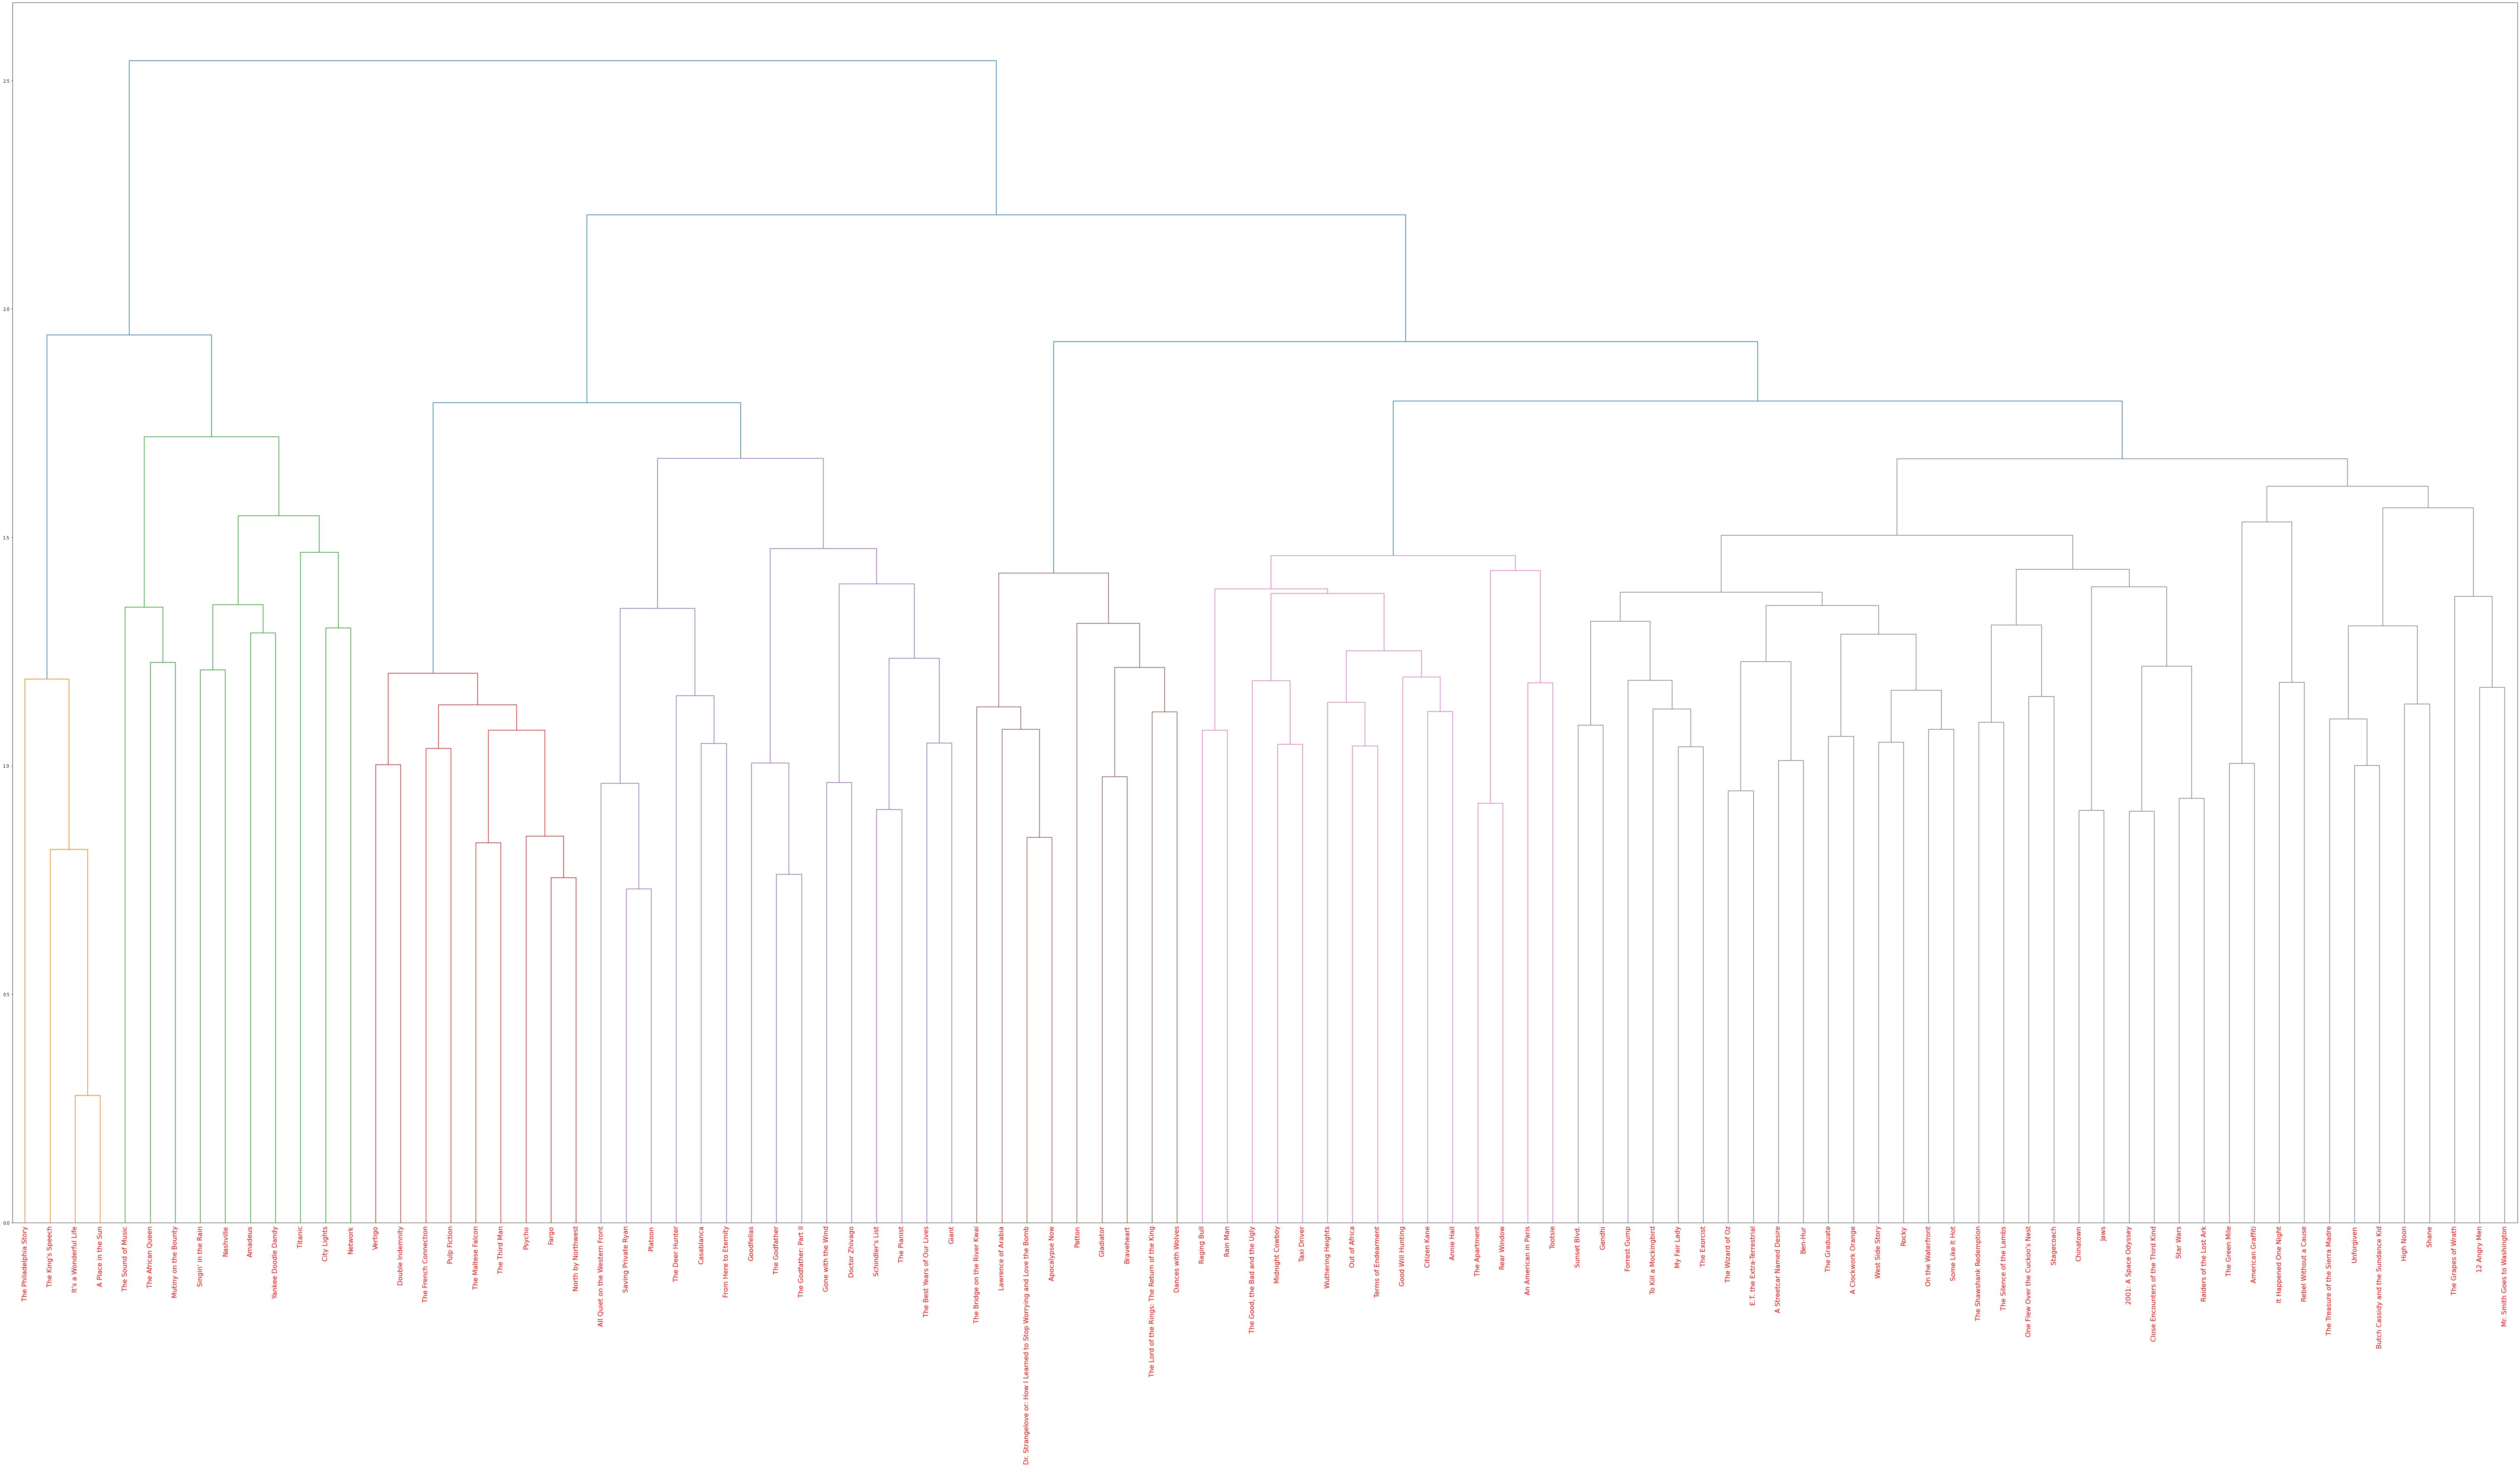

In [17]:
# Create the mergings matrix 
mergings = linkage(similarity_distance, method="complete")

# Plot the dendrogram, using the "title" column as the label
dendrogram_ = dendrogram(
    mergings,
    labels=[title for title in movies_df["title"]],
    leaf_rotation=90,
    leaf_font_size=16,
)

# Adjust the plot
fig = plt.gcf()
_ = [label.set_color("r") for label in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 54)

# Show the plotted dendrogram
plt.show()

<p>Here, the lowest dendrogram linkage we discover here is between the movies, <em>It's a Wonderful Life</em> and <em>A Place in the Sun</em>. This indicates that the movies are very similar to each other in their plots.</p>

## Conclusion
<p>In this project, we used various techniques to analyze the similarity between different movies. We first created a numerical representation of the movies using the TF-IDF vectorizer and removed stopwords to focus on the most important words.</p>
<p>Then, we used k-means clustering to group the movies into different clusters based on their genre. We also calculated the cosine similarity between the movies to measure their similarity and used this measure to create a dendrogram visualization.</p>
<p>Finally, we discovered that the movies <em>It's a Wonderful Life</em> and <em>A Place in the Sun</em> were the most similar to each other in terms of their plots. Overall, this project gave a better understanding of how to analyze and visualize the similarity between different movies using natural language processing techniques.</p>